In [63]:
import cv2, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

image_path = Path("photo_2025-02-26_15-48-06.jpg")
overlap = 0.6
angle_left  = 17.3    # CCW
angle_right = 22.7    # CW
maxNFeatures = 4000
ratio = 0.65

# out_dir = Path("/mnt/data/panorama_kabsch_waldo"); out_dir.mkdir(parents=True, exist_ok=True)

Input: (853, 1280, 3)


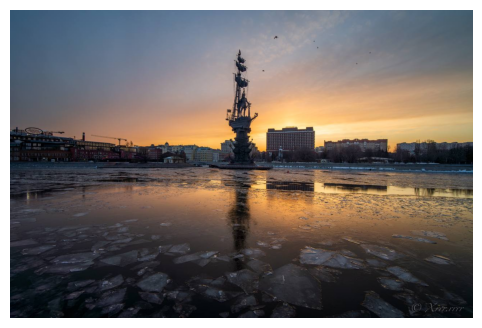

In [64]:
bgr = cv2.imread(str(image_path), cv2.IMREAD_COLOR)
if bgr is None:
    raise RuntimeError("Файл Waldo.png не найден рядом с ноутбуком.")
img = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
print("Input:", img.shape)
plt.figure(figsize=(6,4)); plt.imshow(img); plt.axis("off");

Text(0.5, 1.0, 'Right')

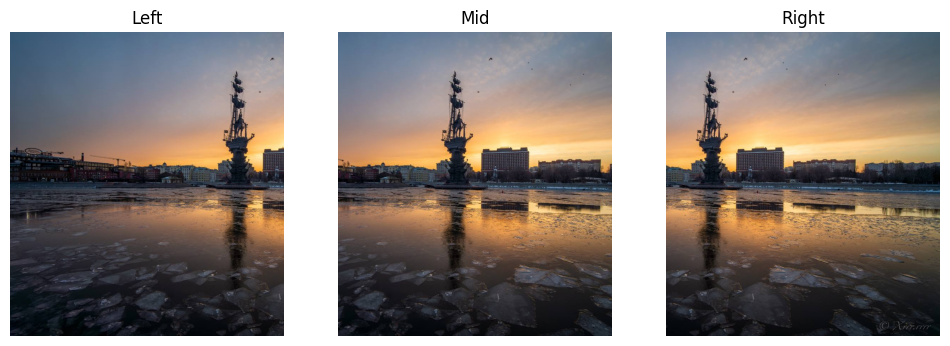

In [65]:
H, W = img.shape[:2]
crop_w = int(0.6 * W)
step = int(crop_w * (1 - overlap))

x0 = 0
x1 = min(W - crop_w, step)
x2 = min(W - crop_w, 2 * step)

crop_left  = img[:, x0:x0+crop_w].copy()
crop_mid   = img[:, x1:x1+crop_w].copy()
crop_right = img[:, x2:x2+crop_w].copy()

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(crop_left);  plt.axis("off"); plt.title("Left")
plt.subplot(1,3,2); plt.imshow(crop_mid);   plt.axis("off"); plt.title("Mid")
plt.subplot(1,3,3); plt.imshow(crop_right); plt.axis("off"); plt.title("Right")

Text(0.5, 1.0, 'Right CW 22.7°')

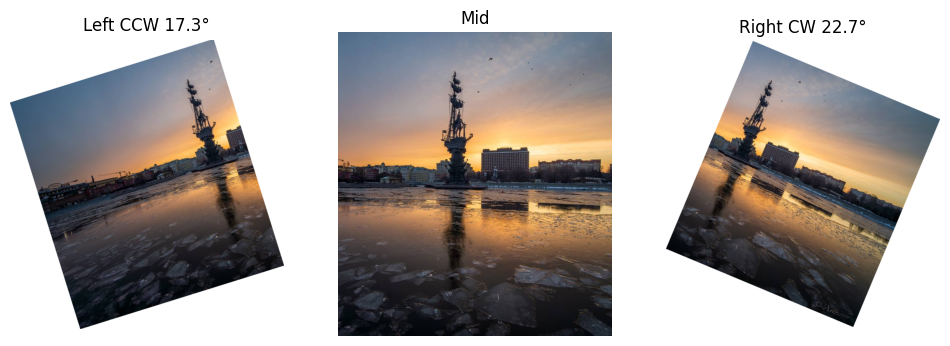

In [66]:
# Поворачиваем левую часть против часовой
hL, wL = crop_left.shape[:2]
cL = (wL/2, hL/2)
ML = cv2.getRotationMatrix2D(cL, angle_left, 1.0)
cosL, sinL = abs(ML[0,0]), abs(ML[0,1])
nWL = int(hL*sinL + wL*cosL)
nHL = int(hL*cosL + wL*sinL)
ML[0,2] += (nWL/2) - cL[0]
ML[1,2] += (nHL/2) - cL[1]
left_rot = cv2.warpAffine(
    crop_left, ML, (nWL, nHL),
    flags=cv2.INTER_LINEAR,
    borderMode=cv2.BORDER_CONSTANT, borderValue=(255,255,255)
)

# Поворачиваем правую часть по часовой
hR, wR = crop_right.shape[:2]
cR = (wR/2, hR/2)
MR = cv2.getRotationMatrix2D(cR, -angle_right, 1.0)
cosR, sinR = abs(MR[0,0]), abs(MR[0,1])
nWR = int(hR*sinR + wR*cosR)
nHR = int(hR*cosR + wR*sinR)
MR[0,2] += (nWR/2) - cR[0]
MR[1,2] += (nHR/2) - cR[1]
right_rot = cv2.warpAffine(
    crop_right, MR, (nWR, nHR),
    flags=cv2.INTER_LINEAR,
    borderMode=cv2.BORDER_CONSTANT, borderValue=(255,255,255)
)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(left_rot);  plt.axis("off"); plt.title(f"Left CCW {angle_left}°")
plt.subplot(1,3,2); plt.imshow(crop_mid);  plt.axis("off"); plt.title("Mid")
plt.subplot(1,3,3); plt.imshow(right_rot); plt.axis("off"); plt.title(f"Right CW {angle_right}°")

LEFT angle_deg: 17.299
LEFT Homography matrix H_L:
[[ 9.45036811e-01 -2.95796470e-01 -2.35304424e+02]
 [ 2.90144591e-01  9.49148959e-01 -2.12871375e+02]
 [-1.23174478e-05  4.33021058e-06  1.00000000e+00]]

H_L shape: (3, 3)
[[ 0.95476484 -0.29736185]
 [ 0.29736185  0.95476484]]


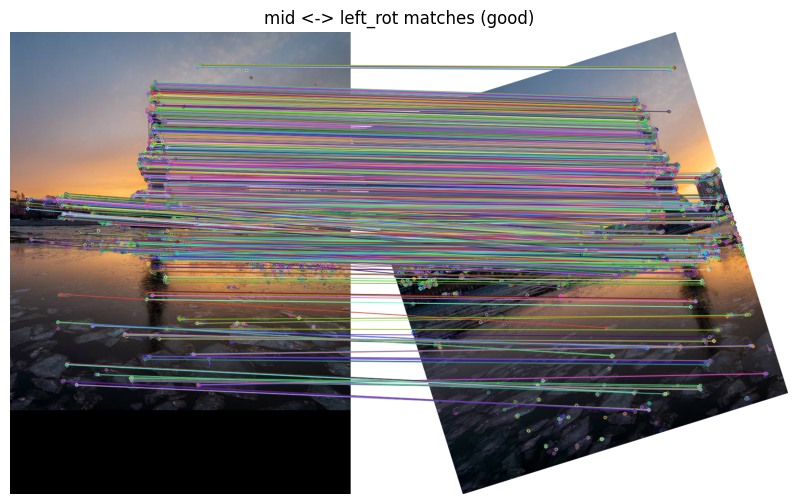

In [67]:
# Находим поворот left -> mid с помощью Kabsch
img1Gray_L = cv2.cvtColor(crop_mid,  cv2.COLOR_RGB2GRAY)   # dst
img2Gray_L = cv2.cvtColor(left_rot,  cv2.COLOR_RGB2GRAY)   # src

orb_L = cv2.ORB_create(maxNFeatures)
kps1_L, d1_L = orb_L.detectAndCompute(img1Gray_L, None)
kps2_L, d2_L = orb_L.detectAndCompute(img2Gray_L, None)
if d1_L is None or d2_L is None:
    raise RuntimeError("пустые дескрипторы (left)")

bf_L = cv2.BFMatcher(cv2.NORM_HAMMING)
m12_L = bf_L.knnMatch(d1_L, d2_L, k=2)

good_L = []
for m, n in m12_L:
    if m.distance < ratio * n.distance:
        good_L.append(m)

pts1_L = np.float32([kps1_L[m.queryIdx].pt for m in good_L]).reshape(-1,2)  # dst
pts2_L = np.float32([kps2_L[m.trainIdx].pt for m in good_L]).reshape(-1,2)  # src

mu1_L = pts1_L.mean(axis=0)
mu2_L = pts2_L.mean(axis=0)
X_L = pts2_L - mu2_L
Y_L = pts1_L - mu1_L

C_L = X_L.T @ Y_L
U_L, S_L, Vt_L = np.linalg.svd(C_L)
R_L = Vt_L.T @ U_L.T
if np.linalg.det(R_L) < 0:
    Vt_L[1,:] *= -1
    R_L = Vt_L.T @ U_L.T

theta_L = np.degrees(np.arctan2(R_L[1,0], R_L[0,0]))
print("LEFT angle_deg:", np.round(theta_L, 3))

imMatches_L = cv2.drawMatches(crop_mid, kps1_L, left_rot, kps2_L, good_L, None)
plt.figure(figsize=(14,6)); plt.imshow(imMatches_L); plt.axis("off"); plt.title("mid <-> left_rot matches (good)")

H_L, mask_L = cv2.findHomography(pts2_L, pts1_L, cv2.RANSAC, 5.0)
print("LEFT Homography matrix H_L:")
print(H_L)
print("\nH_L shape:", H_L.shape)

print(R_L)

768 853
<class 'int'> <class 'int'>


Text(0.5, 1.0, 'Left rotated warped to Mid using H_L')

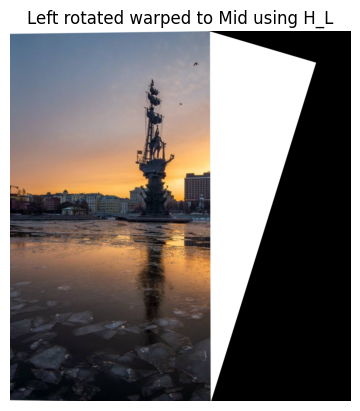

In [68]:
from math import sin, cos, ceil
H_L, mask_L = cv2.findHomography(pts2_L, pts1_L, cv2.RANSAC)
print(crop_mid.shape[1], crop_mid.shape[0])
print(type(crop_mid.shape[1]), type(crop_mid.shape[0]))
left_warped = cv2.warpPerspective(left_rot, H_L, (ceil(crop_mid.shape[1] + crop_mid.shape[1] * cos(angle_left)), crop_mid.shape[0]))

plt.imshow(left_warped); plt.axis("off"); plt.title("Left rotated warped to Mid using H_L")

# left_warped = cv2.warpPerspective(left_rot, H_L, (crop_mid.shape[1], crop_mid.shape[0]))
# plt.imshow(left_warped); plt.axis("off"); plt.title("Left rotated warped to Mid using H_L")


Text(0.5, 1.0, 'Left rotated warped to Mid using H_L')

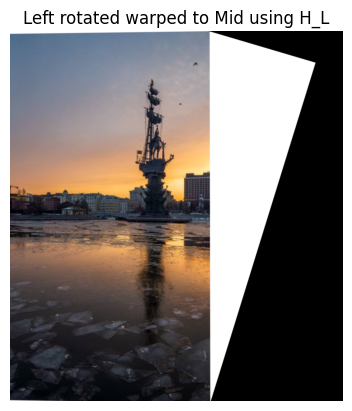

In [82]:
left_warped = cv2.warpPerspective(left_rot, H_L, (crop_mid.shape[1], crop_mid.shape[0]))
plt.imshow(left_warped); plt.axis("off"); plt.title("Left rotated warped to Mid using H_L")

Text(0.5, 1.0, 'Scan')

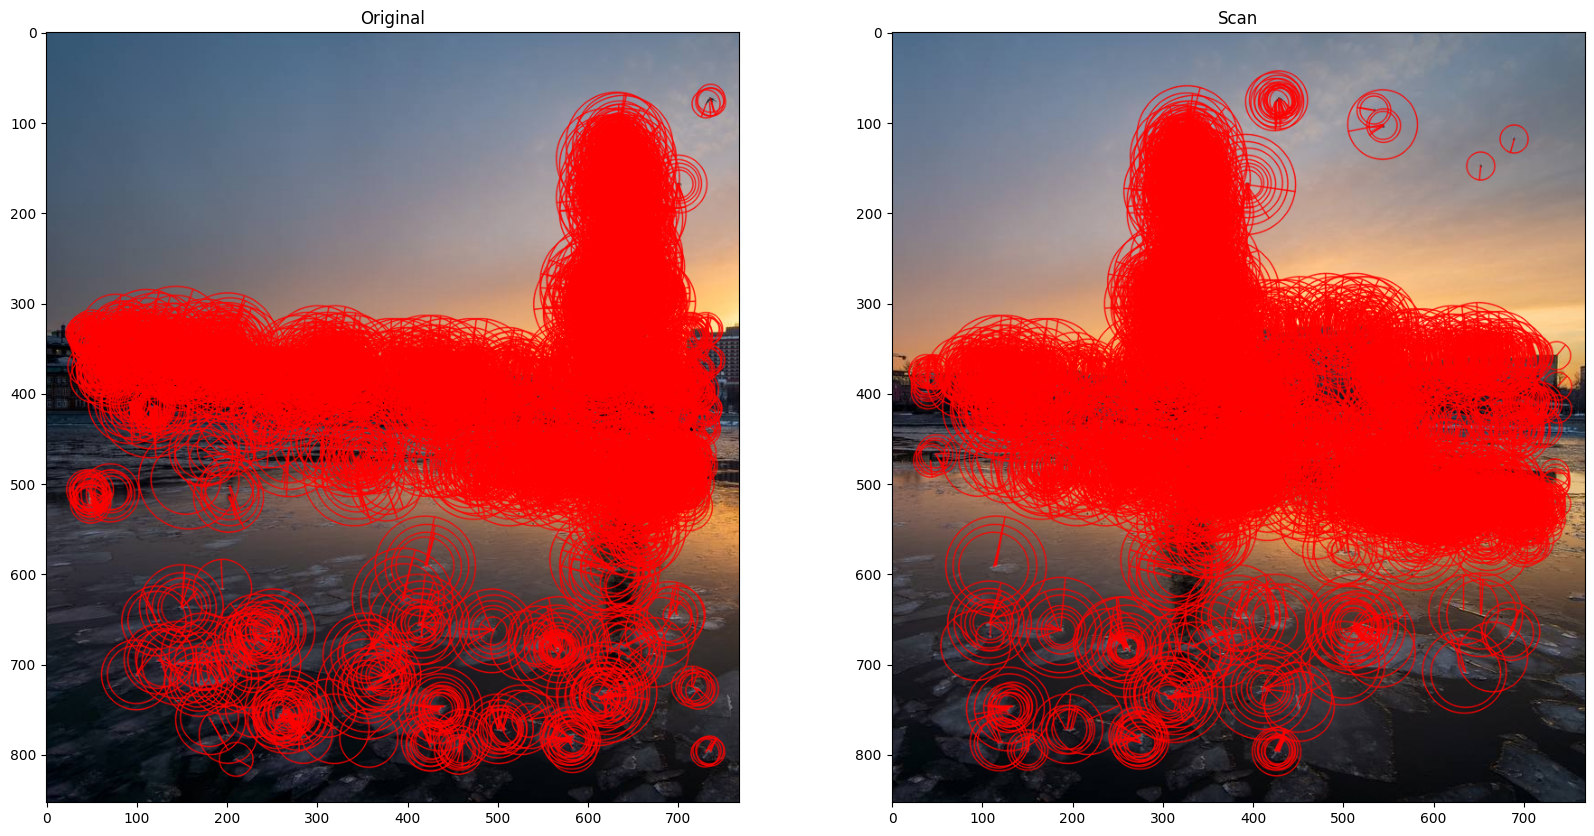

In [70]:
img1Gray = cv2.cvtColor(crop_left, cv2.COLOR_RGB2GRAY)
img2Gray = cv2.cvtColor(crop_mid, cv2.COLOR_RGB2GRAY)

maxNFeatures = 4000
orb = cv2.ORB_create(maxNFeatures)
keypoints1, desc1 = orb.detectAndCompute(img1Gray, None)
keypoints2, desc2 = orb.detectAndCompute(img2Gray, None)

img1ToShow = cv2.drawKeypoints(crop_left, keypoints1, color=(255, 0, 0), outImage = np.array([]), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2ToShow = cv2.drawKeypoints(crop_mid, keypoints2, color=(255, 0, 0), outImage = np.array([]), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=[20, 10])
plt.subplot(121); plt.imshow(img1ToShow); plt.title("Original")
plt.subplot(122); plt.imshow(img2ToShow); plt.title("Scan")

Text(0.5, 1.0, 'mid <-> left_rot matches (good)')

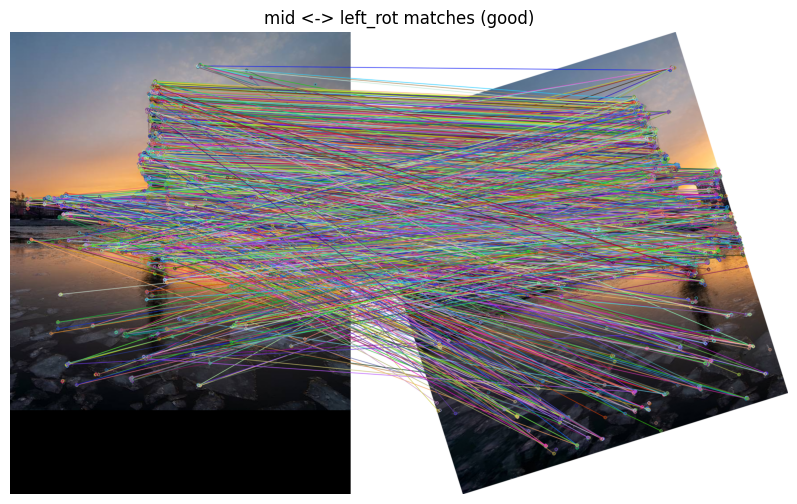

In [85]:
# matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
# matches = matcher.match(desc1, desc2, None)

# matches = list(matches)
# matches.sort(key = lambda x : x.distance, reverse = False)
# nGoodMatches = int(len(matches) * 0.1)
# matches = matches[:nGoodMatches]
bf = cv2.BFMatcher(cv2.NORM_HAMMING)
matches = bf.knnMatch(desc1, desc2, k=2)
# matches = sorted(matches, key=lambda x: x.distance)

good_L = []
for m, n in matches:
    if m.distance < 0.9 * n.distance:
        good_L.append(m)

# m12_L = bf_L.knnMatch(d1_L, d2_L, k=2)

# good_L = []
# for m, n in m12_L:
#     if m.distance < ratio * n.distance:
#         good_L.append(m)

# imMatches = cv2.drawMatches(crop_mid, keypoints1, crop_left, keypoints2, good, None)
imMatches_L = cv2.drawMatches(crop_mid, kps1_L, left_rot, kps2_L, good_L, None)
plt.figure(figsize=(14,6)); plt.imshow(imMatches_L); plt.axis("off"); plt.title("mid <-> left_rot matches (good)")

In [86]:
points1 = np.zeros((len(matches), 2), dtype = np.float32)
points2 = np.zeros((len(matches), 2), dtype = np.float32)

for i, match in enumerate(matches):
    points1[i,:] = keypoints1[match[0].queryIdx].pt
    points2[i,:] = keypoints2[match[0].trainIdx].pt

h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

print(h)

[[ 1.00067789e+00 -2.87704398e-04  3.07067383e+02]
 [ 9.55027009e-04  1.00023832e+00 -3.15104303e-01]
 [ 1.61636697e-06 -5.16423503e-07  1.00000000e+00]]


Text(0.5, 1.0, 'Scan updated')

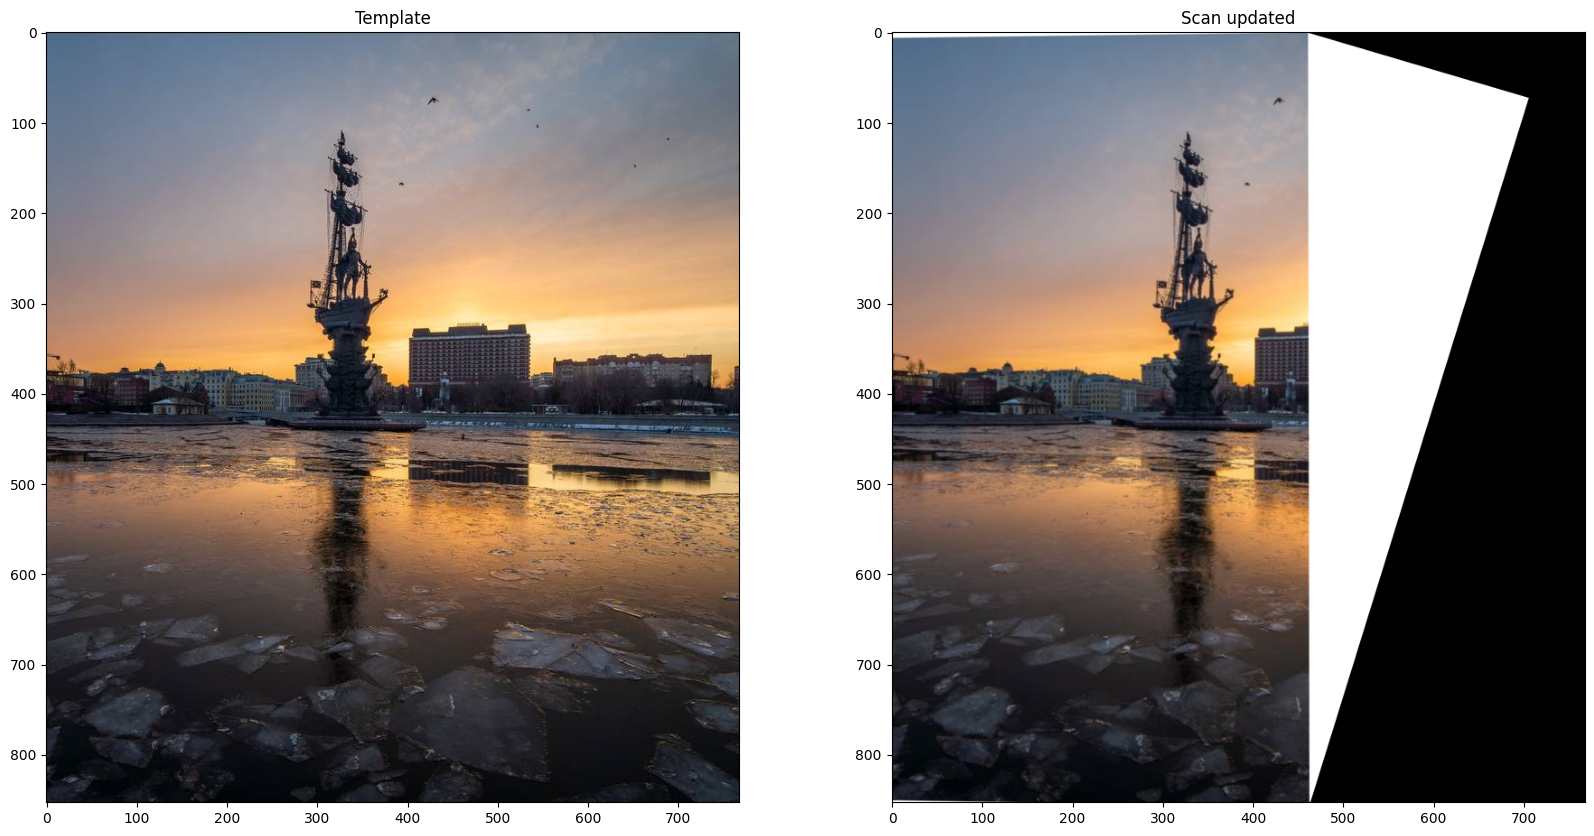

: 

In [ ]:
height, width, _ = crop_mid.shape
left_rot_back = cv2.warpPerspective(left_rot, H_L, (width, height))

plt.figure(figsize = [20, 10])
plt.subplot(121); plt.imshow(crop_mid); plt.title("Template")
plt.subplot(122); plt.imshow(left_rot_back); plt.title("Scan updated")

RIGHT angle_deg: -22.663


Text(0.5, 1.0, 'mid <-> right_rot matches (good)')

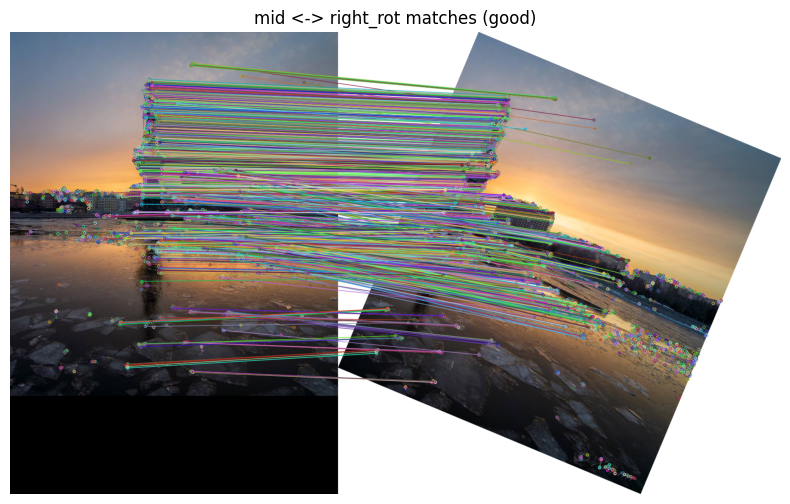

In [ ]:
# RIGHT: оценка чистой матрицы поворота R_R (без использования t из матчей)
img1Gray_R = cv2.cvtColor(crop_mid,   cv2.COLOR_RGB2GRAY)  # dst
img2Gray_R = cv2.cvtColor(right_rot,  cv2.COLOR_RGB2GRAY)  # src

orb_R = cv2.ORB_create(maxNFeatures)
kps1_R, d1_R = orb_R.detectAndCompute(img1Gray_R, None)
kps2_R, d2_R = orb_R.detectAndCompute(img2Gray_R, None)
if d1_R is None or d2_R is None:
    raise RuntimeError("ORB: пустые дескрипторы (right)")

bf_R = cv2.BFMatcher(cv2.NORM_HAMMING)
m12_R = bf_R.knnMatch(d1_R, d2_R, k=2)

good_R = []
for m, n in m12_R:
    if m.distance < ratio * n.distance:
        good_R.append(m)
if len(good_R) < 6:
    raise RuntimeError(f"Too few good matches (right): {len(good_R)}")

pts1_R = np.float32([kps1_R[m.queryIdx].pt for m in good_R]).reshape(-1,2)  # dst
pts2_R = np.float32([kps2_R[m.trainIdx].pt for m in good_R]).reshape(-1,2)  # src

mu1_R = pts1_R.mean(axis=0)
mu2_R = pts2_R.mean(axis=0)
X_R = pts2_R - mu2_R
Y_R = pts1_R - mu1_R

C_R = X_R.T @ Y_R
U_R, S_R, Vt_R = np.linalg.svd(C_R)
R_R = Vt_R.T @ U_R.T
if np.linalg.det(R_R) < 0:
    Vt_R[1,:] *= -1
    R_R = Vt_R.T @ U_R.T

theta_R = np.degrees(np.arctan2(R_R[1,0], R_R[0,0]))
print("RIGHT angle_deg:", np.round(theta_R, 3))

imMatches_R = cv2.drawMatches(crop_mid, kps1_R, right_rot, kps2_R, good_R, None)
plt.figure(figsize=(14,6)); plt.imshow(imMatches_R); plt.axis("off"); plt.title("mid <-> right_rot matches (good)")


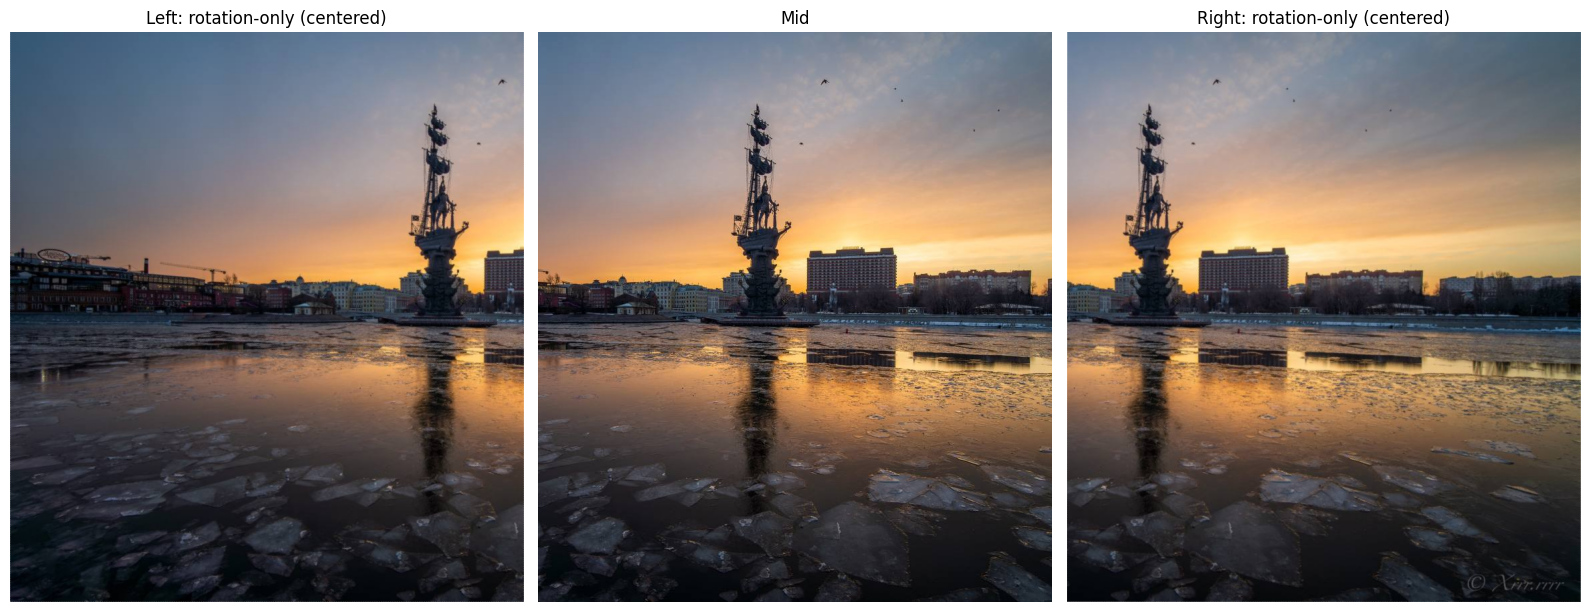

In [ ]:
th, tw = crop_mid.shape[:2]
c_mid  = np.array([tw/2.0, th/2.0], dtype=np.float32)

hL, wL = left_rot.shape[:2]
c_left  = np.array([wL/2.0, hL/2.0], dtype=np.float32)
hR, wR = right_rot.shape[:2]
c_right = np.array([wR/2.0, hR/2.0], dtype=np.float32)

tL_canvas = c_mid - (R_L @ c_left)
A_L_rot_only = np.hstack([R_L, tL_canvas.reshape(2,1)])

tR_canvas = c_mid - (R_R @ c_right)
A_R_rot_only = np.hstack([R_R, tR_canvas.reshape(2,1)])

left_rot_only  = cv2.warpAffine(
    left_rot, A_L_rot_only, (tw, th),
    flags=cv2.INTER_LINEAR,
    borderMode=cv2.BORDER_CONSTANT, borderValue=(255,255,255)
)
right_rot_only = cv2.warpAffine(
    right_rot, A_R_rot_only, (tw, th),
    flags=cv2.INTER_LINEAR,
    borderMode=cv2.BORDER_CONSTANT, borderValue=(255,255,255)
)

plt.figure(figsize=(16,7))
plt.subplot(1,3,1); plt.imshow(left_rot_only);  plt.axis("off"); plt.title("Left: rotation-only (centered)")
plt.subplot(1,3,2); plt.imshow(crop_mid);       plt.axis("off"); plt.title("Mid")
plt.subplot(1,3,3); plt.imshow(right_rot_only); plt.axis("off"); plt.title("Right: rotation-only (centered)")
plt.tight_layout()


Text(0.5, 1.0, 'Stitcher panorama')

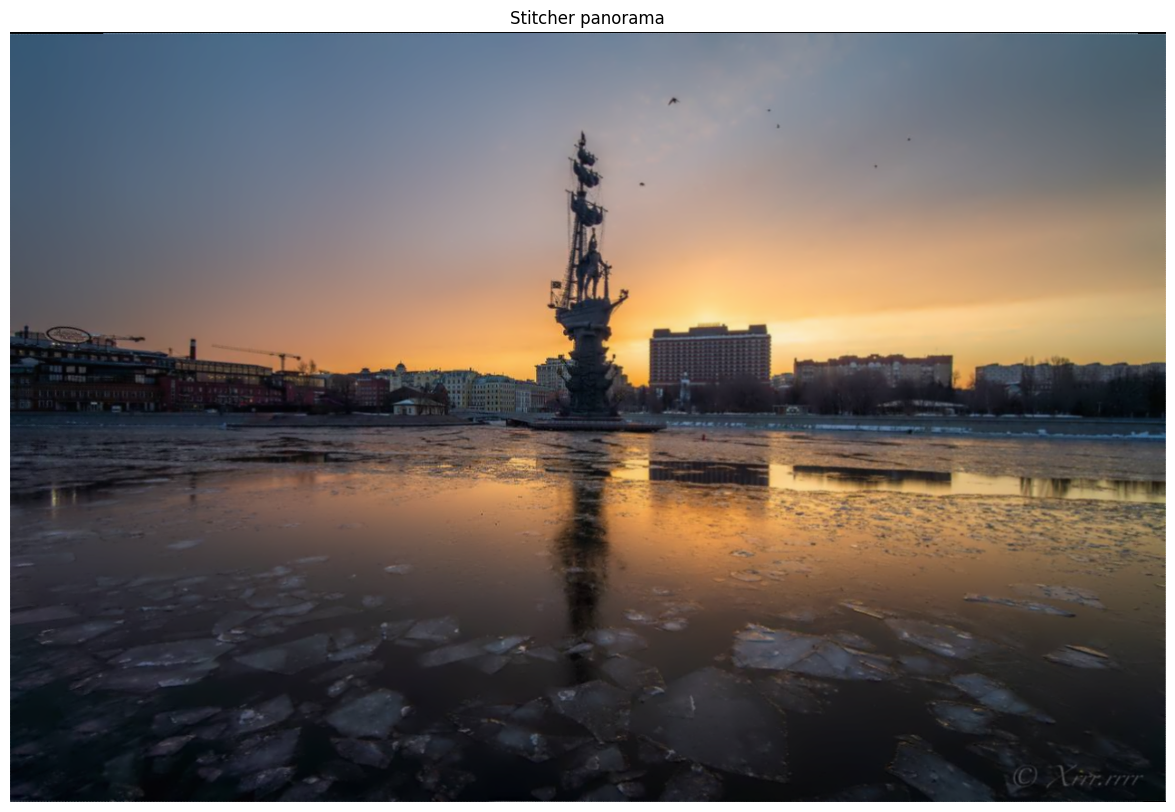

In [ ]:
images_bgr = [
    cv2.cvtColor(left_rot_only, cv2.COLOR_RGB2BGR),
    cv2.cvtColor(crop_mid,      cv2.COLOR_RGB2BGR),
    cv2.cvtColor(right_rot_only,cv2.COLOR_RGB2BGR),
]

stitcher = cv2.Stitcher_create()
retval, pano_bgr = stitcher.stitch(images_bgr, )

pano = cv2.cvtColor(pano_bgr, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(30,10)); plt.imshow(pano); plt.axis("off"); plt.title("Stitcher panorama")